# Sepsis Data ML Preprocessing

### Imports

In [42]:
!pip install kagglehub


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
!pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import kagglehub
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

from scipy.stats import mstats  # for winsorization

## Data Download

In [45]:
import kagglehub
from pathlib import Path
import shutil

download_path = kagglehub.dataset_download("salikhussaini49/prediction-of-sepsis")
print("Downloaded dataset to cache:", download_path)


Downloaded dataset to cache: C:\Users\marta\.cache\kagglehub\datasets\salikhussaini49\prediction-of-sepsis\versions\2


In [46]:
PROJECT_ROOT = Path.cwd().parents[1] if (Path.cwd().name == "notebooks") else Path.cwd()

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_RAW.mkdir(parents=True, exist_ok=True)  # ensure folder exists

print("📂 Raw data folder:", DATA_RAW)


📂 Raw data folder: C:\Users\marta\PyCharmMiscProject\data\raw


In [47]:
shutil.copytree(download_path, DATA_RAW, dirs_exist_ok=True)

print("📦 Copied dataset files into:", DATA_RAW)
print("Contents:", list(DATA_RAW.iterdir()))


📦 Copied dataset files into: C:\Users\marta\PyCharmMiscProject\data\raw
Contents: [WindowsPath('C:/Users/marta/PyCharmMiscProject/data/raw/Dataset.csv'), WindowsPath('C:/Users/marta/PyCharmMiscProject/data/raw/LICENSE.txt'), WindowsPath('C:/Users/marta/PyCharmMiscProject/data/raw/physionet_challenge_2019_ccm_manuscript.pdf'), WindowsPath('C:/Users/marta/PyCharmMiscProject/data/raw/SHA256SUMS.txt'), WindowsPath('C:/Users/marta/PyCharmMiscProject/data/raw/training_setA'), WindowsPath('C:/Users/marta/PyCharmMiscProject/data/raw/training_setB'), WindowsPath('C:/Users/marta/PyCharmMiscProject/data/raw/utility_nonsepsis_diagram.svg'), WindowsPath('C:/Users/marta/PyCharmMiscProject/data/raw/utility_sepsis_diagram.svg')]


In [48]:
# 5) Now load the CSV from the RAW directory — not from a user path
csv_path = DATA_RAW / "Dataset.csv"
df = pd.read_csv(csv_path)

# Drop the first column (index-like)
df = df.iloc[:, 1:]

df.head()


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


## Data Audit

### General Data Description

In [49]:
# Basic structural audit
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

Shape: (1552210, 43)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 43 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Hour              1552210 non-null  int64  
 1   HR                1398811 non-null  float64
 2   O2Sat             1349474 non-null  float64
 3   Temp              525226 non-null   float64
 4   SBP               1325945 non-null  float64
 5   MAP               1358940 non-null  float64
 6   DBP               1065656 non-null  float64
 7   Resp              1313875 non-null  float64
 8   EtCO2             57636 non-null    float64
 9   BaseExcess        84145 non-null    float64
 10  HCO3              65028 non-null    float64
 11  FiO2              129365 non-null   float64
 12  pH                107573 non-null   float64
 13  PaCO2             86301 non-null    float64
 14  SaO2              53561 non-null    float64
 15  AST               251

In [50]:
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
Hour                      0
HR                   153399
O2Sat                202736
Temp                1026984
SBP                  226265
MAP                  193270
DBP                  486554
Resp                 238335
EtCO2               1494574
BaseExcess          1468065
HCO3                1487182
FiO2                1422845
pH                  1444637
PaCO2               1465909
SaO2                1498649
AST                 1527027
BUN                 1445642
Alkalinephos        1527269
Calcium             1460879
Chloride            1481744
Creatinine          1457594
Bilirubin_direct    1549220
Glucose             1286694
Lactate             1510764
Magnesium           1454259
Phosphate           1489909
Potassium           1407685
Bilirubin_total     1529069
TroponinI           1537429
Hct                 1414777
Hgb                 1437619
PTT                 1506511
WBC                 1452763
Fibrinogen          1541968
Platelets           

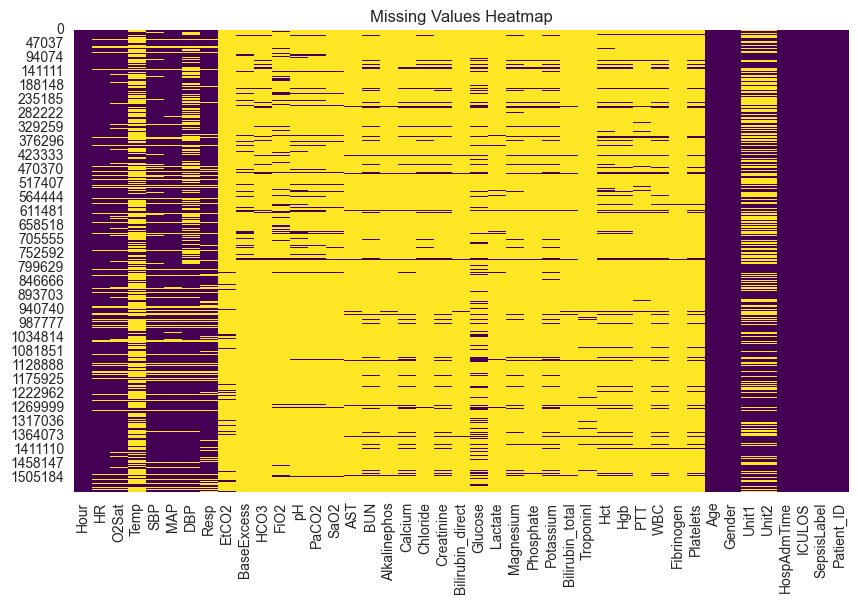

In [51]:
# Reset figure registry at the FIRST plotting step 3.1
EXPORTED_FIGURES = []

# ---- Missing values heatmap (Step 3.1)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', ax=ax)
ax.set_title("Missing Values Heatmap")

# Save this figure in registry
EXPORTED_FIGURES.append(("step3.1_missing_values_heatmap", fig))

plt.show()


Target distribution:
SepsisLabel
0    1524294
1      27916
Name: count, dtype: int64
SepsisLabel
0    0.982015
1    0.017985
Name: proportion, dtype: float64


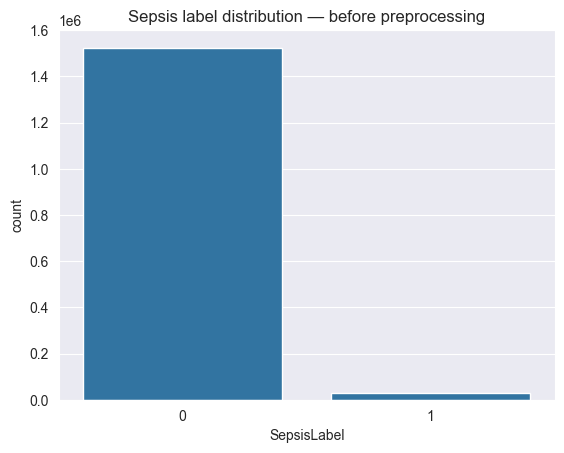

In [52]:
# Check of crucial parameters
P_ID_COL   = "Patient_ID"    # patient identifier
TIME_COL   = "ICULOS"        # hour index in ICU / time step
TARGET_COL = "SepsisLabel"   # 0/1 label - THIS IS OUR TARGET ⚡

for c in [P_ID_COL, TIME_COL, TARGET_COL]:
    assert c in df.columns, f"Column {c} not found, please adjust its name."

# Basic stats
print("\nTarget distribution:")
print(df[TARGET_COL].value_counts(dropna=False))
print(df[TARGET_COL].value_counts(normalize=True))

# Target imbalance plot
fig, ax = plt.subplots()
sns.countplot(x=TARGET_COL, data=df, ax=ax)
ax.set_title("Sepsis label distribution — before preprocessing")
ax.set_xlabel(TARGET_COL)
ax.set_ylabel("count")

# Register this figure for export
EXPORTED_FIGURES.append(("step3.1_target_distribution_before_preprocessing", fig))

plt.show()


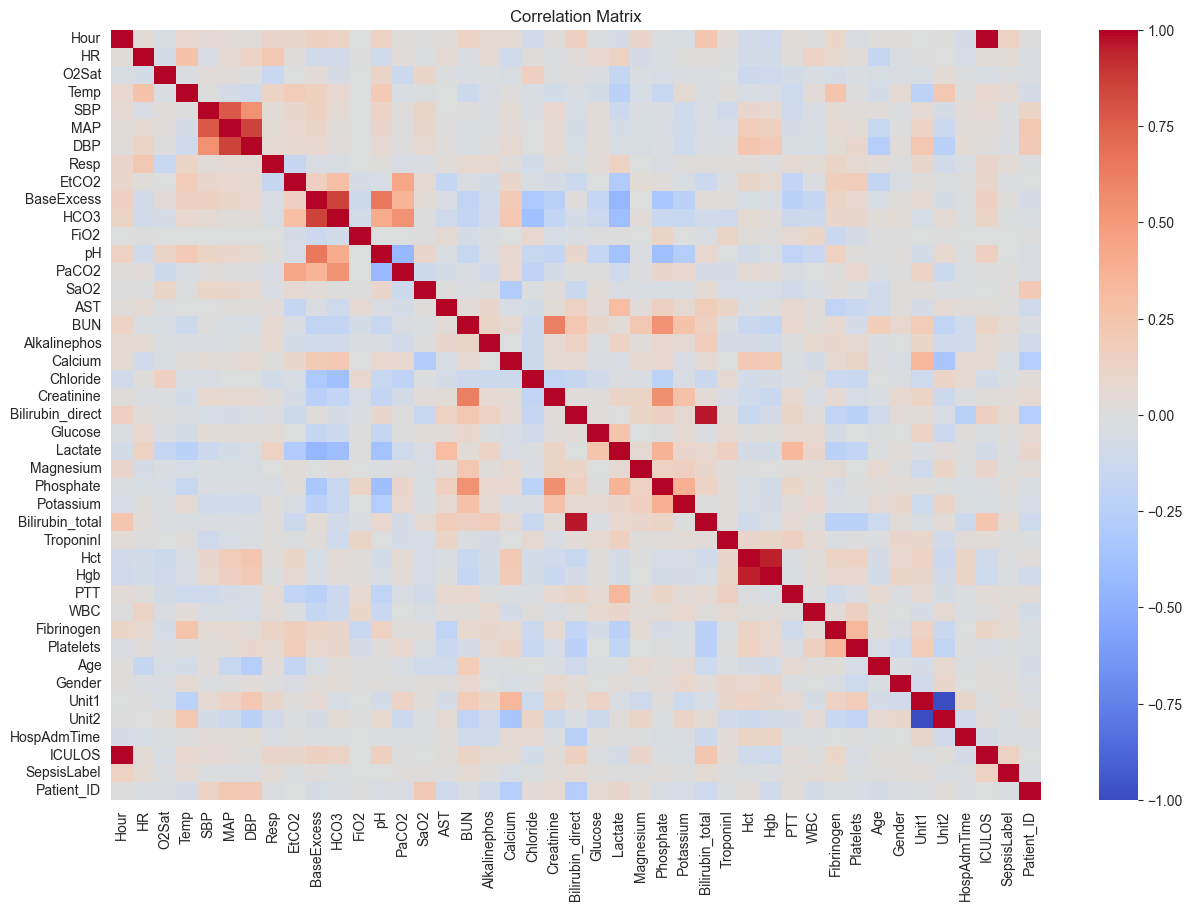

In [53]:
# Data correlation heatmap
fig, ax = plt.subplots(figsize=(15, 10))
correlation = df.corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', cbar=True, ax=ax)
ax.set_title("Correlation Matrix")

# Register figure
EXPORTED_FIGURES.append(("step3.1_correlation_matrix", fig))

plt.show()

### Identification of potential features + distributions

Numeric features (first 20): ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride']
Categorical features: []


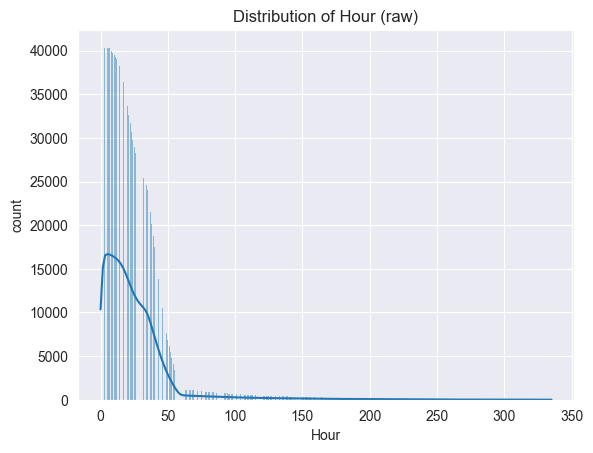

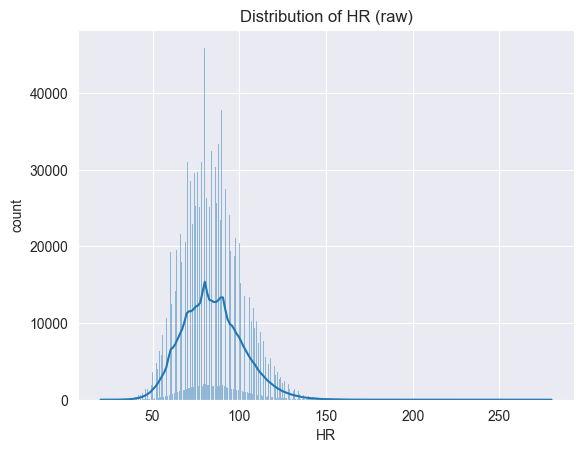

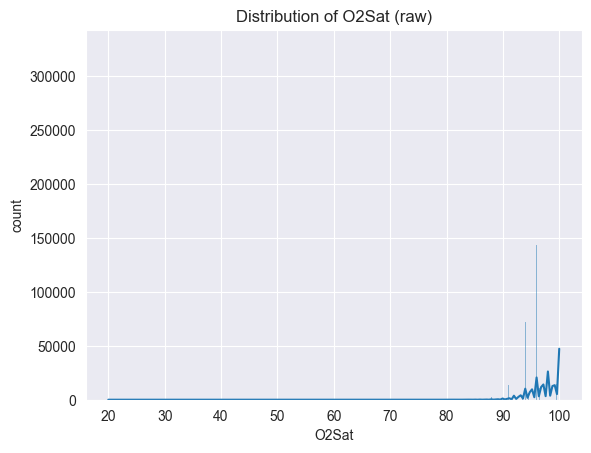

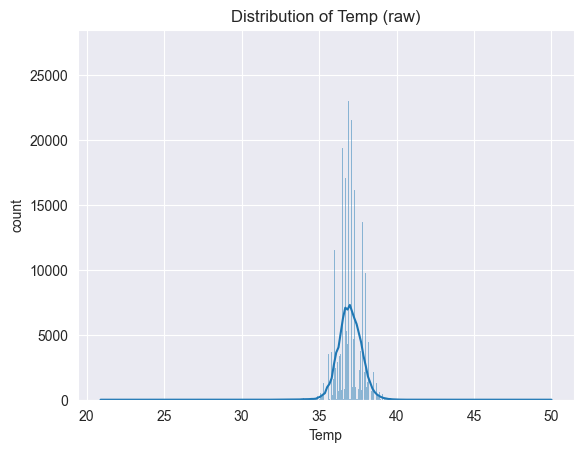

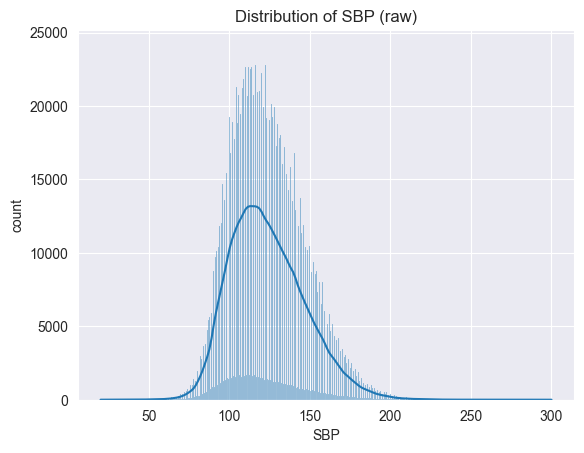

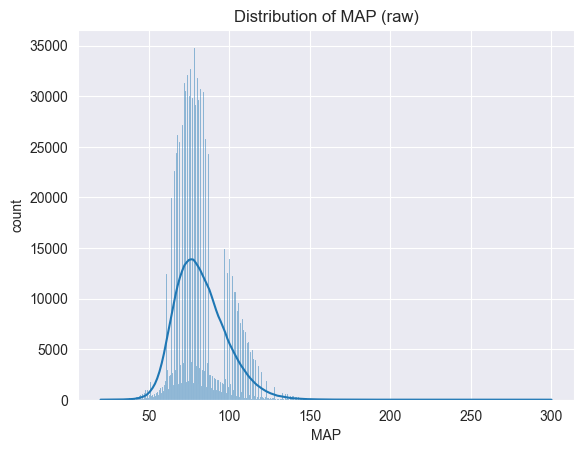

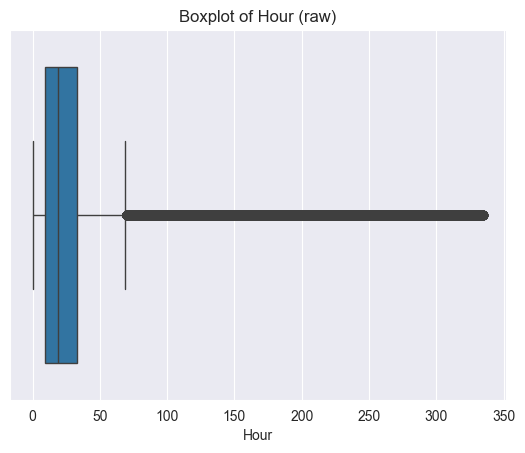

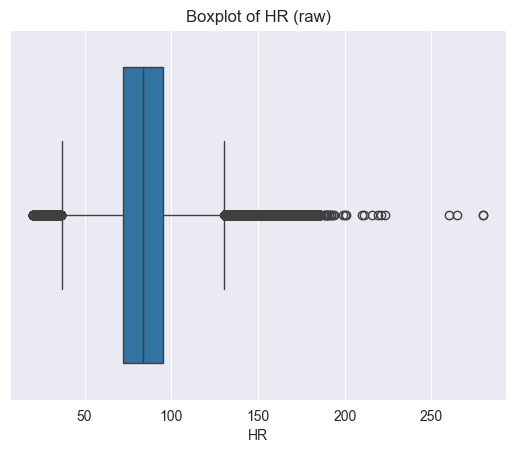

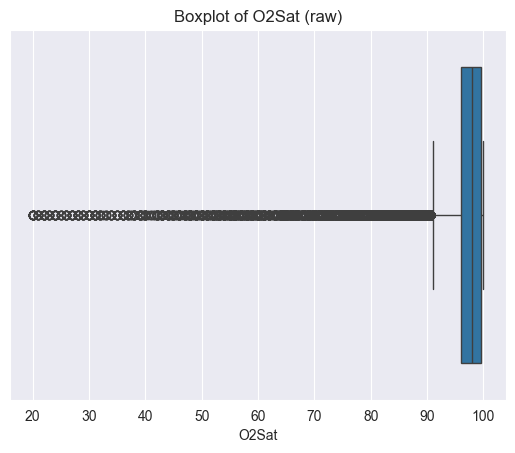

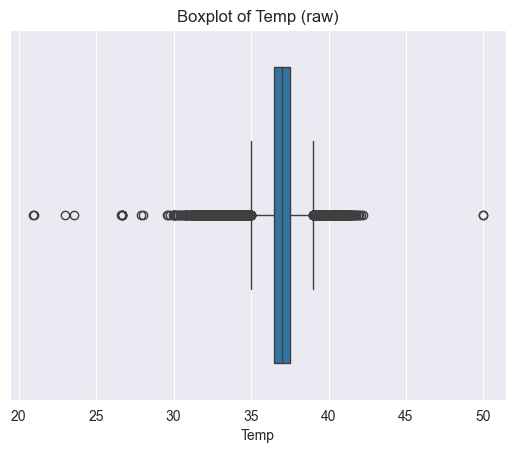

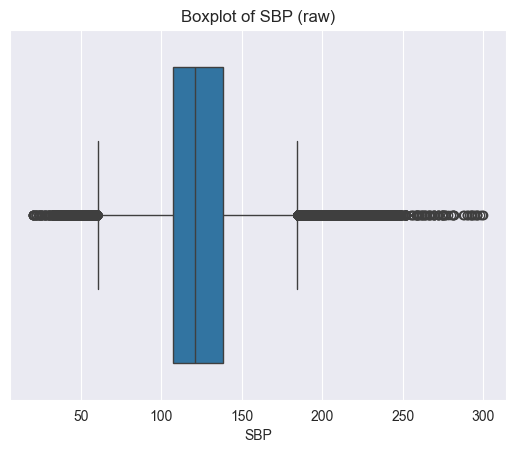

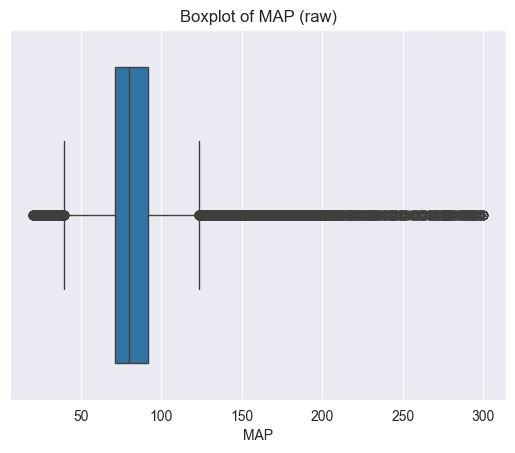

In [54]:
# List of potential columns used to be features

candidate_features = [
    col for col in df.columns if col not in [P_ID_COL, TIME_COL, TARGET_COL]
]

numeric_cols = [c for c in candidate_features if np.issubdtype(df[c].dtype, np.number)]
categorical_cols = [c for c in candidate_features if c not in numeric_cols]

print("Numeric features (first 20):", numeric_cols[:20])
print("Categorical features:", categorical_cols)

# We will visualize first 6 numerical columns
cols_to_plot = numeric_cols[:6]

# ---- Histograms of raw numerical features
for col in cols_to_plot:
    fig, ax = plt.subplots()
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col} (raw)")
    ax.set_xlabel(col)
    ax.set_ylabel("count")

    # Register this figure for export
    EXPORTED_FIGURES.append((f"step3.2_hist_{col}_raw", fig))

    plt.show()

# ---- Boxplots of raw numerical features
for col in cols_to_plot:
    fig, ax = plt.subplots()
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Boxplot of {col} (raw)")
    ax.set_xlabel(col)

    # Register this figure for export
    EXPORTED_FIGURES.append((f"step3.2_box_{col}_raw", fig))

    plt.show()


### Time-series analysis

Example sepsis patient: 117534
Example non-sepsis patient: 9561


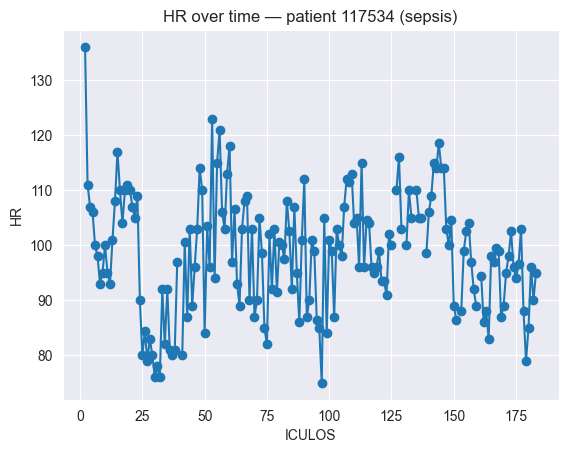

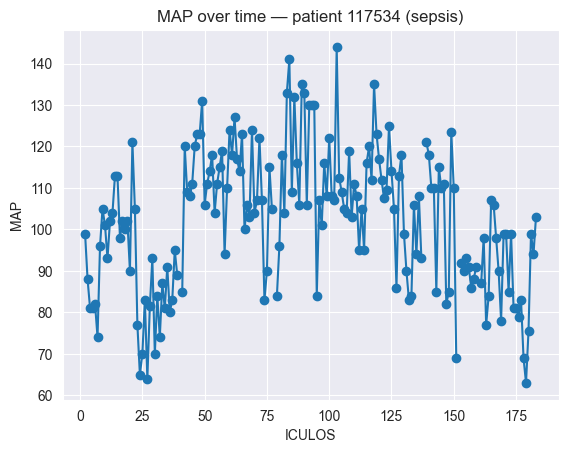

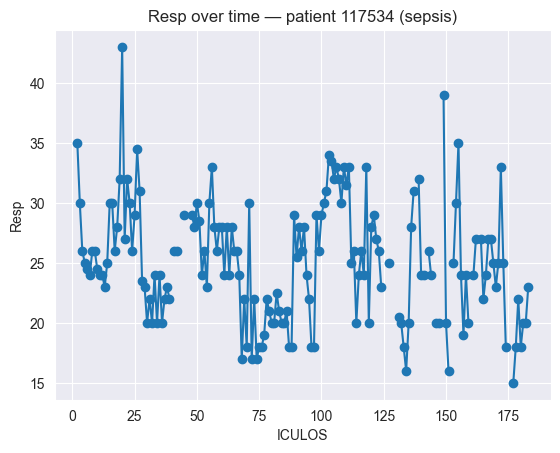

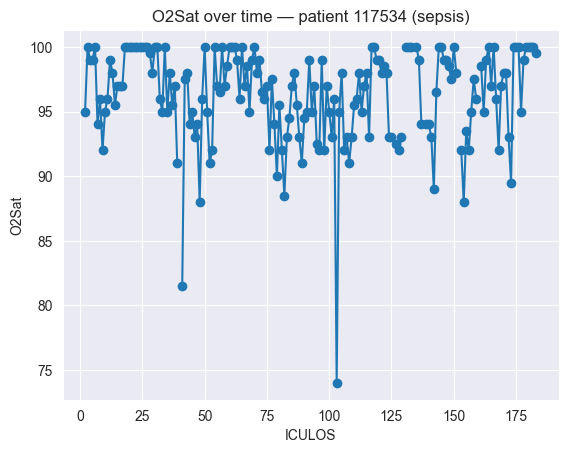

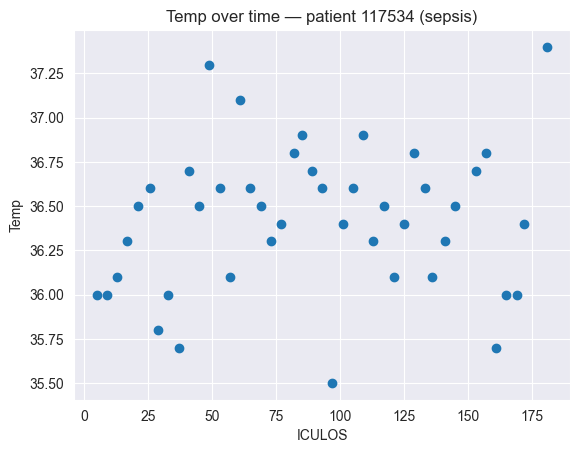

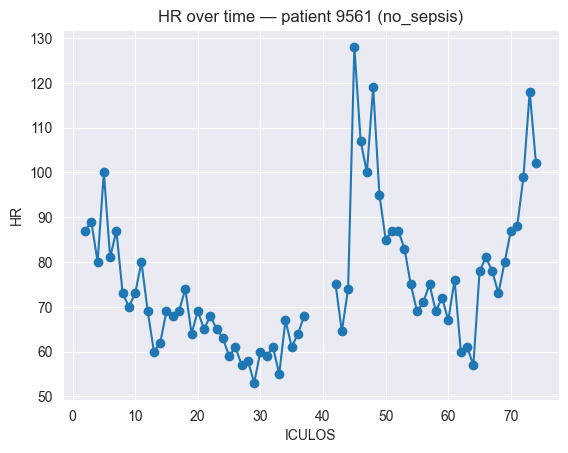

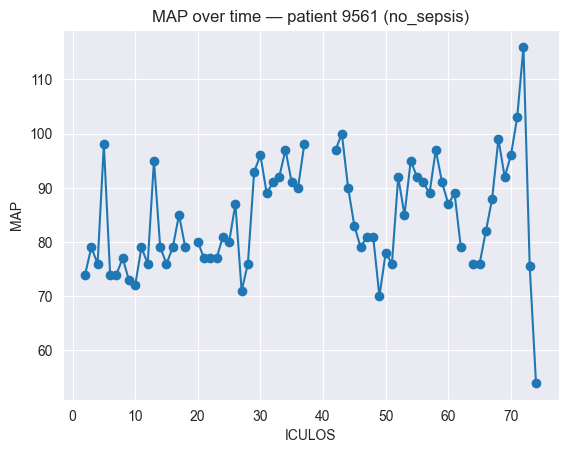

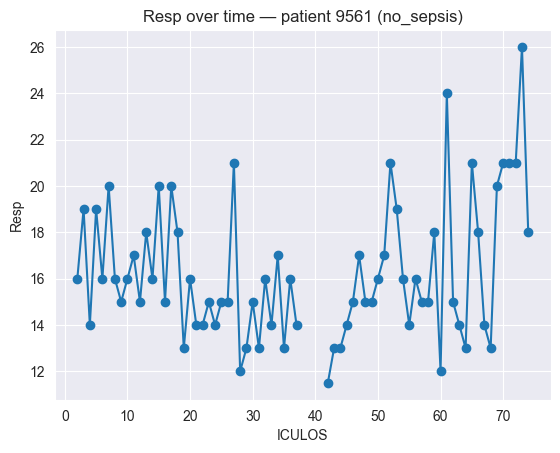

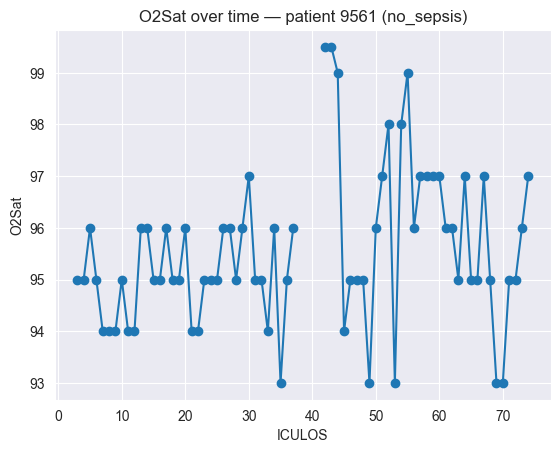

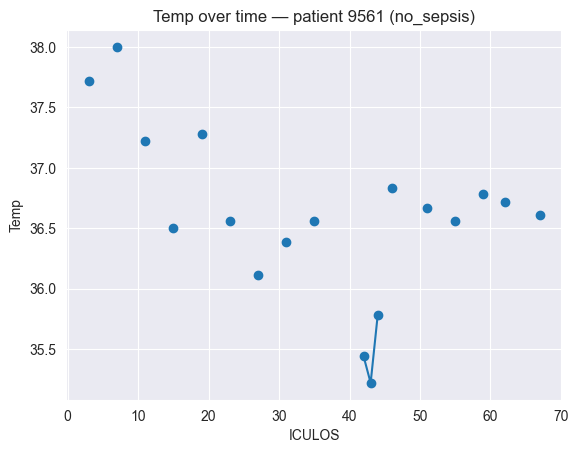

In [55]:
# Identify example patients
pos_patients = df.loc[df[TARGET_COL] == 1, P_ID_COL].unique()  # patient with sepsis ( :( )
neg_patients = df.loc[df[TARGET_COL] == 0, P_ID_COL].unique()  # patient with no sepsis (yay good for them)

if len(pos_patients) > 0:
    example_pos = np.random.choice(pos_patients)
    print("Example sepsis patient:", example_pos)
else:
    example_pos = None
    print("No positive patients found (check labels).")

if len(neg_patients) > 0:
    example_neg = np.random.choice(neg_patients)
    print("Example non-sepsis patient:", example_neg)
else:
    example_neg = None
    print("No negative patients found (check labels).")

# Physiological variables to visualize
ts_vars = [v for v in ["HR", "MAP", "Resp", "O2Sat", "Temp"] if v in df.columns]

def plot_patient_timeseries(patient_id, tag):
    """Plots time series for selected variables for a single patient."""
    sub = df[df[P_ID_COL] == patient_id].sort_values(TIME_COL)
    for v in ts_vars:
        fig, ax = plt.subplots()
        ax.plot(sub[TIME_COL], sub[v], marker="o")
        ax.set_title(f"{v} over time — patient {patient_id} ({tag})")
        ax.set_xlabel(TIME_COL)
        ax.set_ylabel(v)
        ax.grid(True)

        # Register this figure for export
        fig_name = f"step4_patient_{tag}_id{patient_id}_{v}_timeseries"
        EXPORTED_FIGURES.append((fig_name, fig))

        plt.show()

# Plot example patients
if example_pos is not None:
    plot_patient_timeseries(example_pos, "sepsis")

if example_neg is not None:
    plot_patient_timeseries(example_neg, "no_sepsis")


## Handling missing values and outliers

In [56]:
# dropping the data with the rule of thumb
threshold = 0.90
missing_ratio = df.isna().mean()

cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()

print("Columns sashay away (>90% missing):", cols_to_drop)
print("Count:", len(cols_to_drop))

df = df.drop(columns=cols_to_drop)
print("New shape after drop:", df.shape)


Columns sashay away (>90% missing): ['EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets']
Count: 26
New shape after drop: (1552210, 17)


In [57]:
# handling the rest of NaNs
df = df.sort_values([P_ID_COL, TIME_COL])

# forward and backward fill PER PATIENT
df = df.groupby(P_ID_COL, group_keys=False).apply(lambda x: x.ffill().bfill())

# median fallback for any remaining NaNs
for col in df.columns:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

print("Missing values after cleaning:")
print(df.isna().sum().sort_values(ascending=False))


C:\Users\marta\AppData\Local\Temp\ipykernel_54964\3639771998.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(P_ID_COL, group_keys=False).apply(lambda x: x.ffill().bfill())


Missing values after cleaning:
Hour           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
Glucose        0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
Patient_ID     0
dtype: int64


In [58]:
import numpy as np
import scipy.stats.mstats as mstats  # for Winsorization

# Re-detect numeric columns
all_numeric = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove the key columns from treatment
numeric_cols = [c for c in all_numeric if c not in [P_ID_COL, TIME_COL, TARGET_COL]]

print("Numeric columns selected for outlier capping:", numeric_cols)

def is_binary(series):
    vals = series.dropna().unique()
    return len(vals) <= 2 and set(vals).issubset({0, 1})

winsorized_df = df.copy()

for col in numeric_cols:
    if is_binary(winsorized_df[col]):  # skip binary columns
        print(f"Skipping {col} (binary)")
        continue

    vals = winsorized_df[col].values
    mask = ~np.isnan(vals)

    if mask.sum() > 20:  # require enough data to determine limits
        original = vals[mask].copy()
        capped = mstats.winsorize(original, limits=[0.01, 0.01])  # 1% cap bottom/top
        vals[mask] = capped
        winsorized_df[col] = vals
        print(f"Winsorized {col} (n={mask.sum()})")
    else:
        print(f"Not enough data to winsorize {col} (n={mask.sum()})")

df = winsorized_df

print("Feature ranges after Winsorization:")
for col in numeric_cols:
    print(f"{col}: min = {df[col].min():.2f}, max = {df[col].max():.2f}")


Numeric columns selected for outlier capping: ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Glucose', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime']
Winsorized Hour (n=1552210)
Winsorized HR (n=1552210)
Winsorized O2Sat (n=1552210)
Winsorized Temp (n=1552210)
Winsorized SBP (n=1552210)
Winsorized MAP (n=1552210)
Winsorized DBP (n=1552210)
Winsorized Resp (n=1552210)
Winsorized Glucose (n=1552210)
Winsorized Age (n=1552210)
Skipping Gender (binary)
Skipping Unit1 (binary)
Skipping Unit2 (binary)
Winsorized HospAdmTime (n=1552210)
Feature ranges after Winsorization:
Hour: min = 0.00, max = 164.00
HR: min = 50.00, max = 130.00
O2Sat: min = 89.00, max = 100.00
Temp: min = 35.20, max = 38.67
SBP: min = 79.50, max = 186.00
MAP: min = 52.00, max = 128.00
DBP: min = 38.00, max = 102.00
Resp: min = 8.00, max = 34.00
Glucose: min = 66.00, max = 305.00
Age: min = 21.00, max = 89.00
Gender: min = 0.00, max = 1.00
Unit1: min = 0.00, max = 1.00
Unit2: min = 0.00, max = 1.00
HospAd

## Normalization

In [59]:
# re-detect numeric columns
all_numeric = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in all_numeric if c not in [P_ID_COL, TIME_COL, TARGET_COL]]

print("Numeric columns for scaling:", numeric_cols)

# Patient-wise split
patients = df[P_ID_COL].unique()
train_pats, test_pats = train_test_split(patients, test_size=0.2, random_state=42)

train_df = df[df[P_ID_COL].isin(train_pats)].copy()
test_df  = df[df[P_ID_COL].isin(test_pats)].copy()

print("Train shape:", train_df.shape, " | Test shape:", test_df.shape)

# scaling features using Z-score standardization
scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols]  = scaler.transform(test_df[numeric_cols])

print("Example scaled feature preview:")
print(train_df[numeric_cols[:5]].head())


Numeric columns for scaling: ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Glucose', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime']
Train shape: (1241213, 17)  | Test shape: (310997, 17)
Example scaled feature preview:
            Hour        HR     O2Sat      Temp       SBP
132940 -0.981406  0.738859 -0.890076 -1.095866 -1.132851
132941 -0.942007  0.738859 -0.890076 -1.095866 -1.132851
132942 -0.902609  0.269532  0.700883 -1.095866 -0.070135
132943 -0.863210  0.328198 -0.890076 -1.095866 -0.070135
132944 -0.823812  1.090853 -3.276514 -1.095866 -0.070135


## Final Summary

🔍 SepsisLabel ratio in TRAIN set:
SepsisLabel
0    1218544
1      22669
Name: count, dtype: int64
SepsisLabel
0    0.981736
1    0.018264
Name: proportion, dtype: float64

🔍 SepsisLabel ratio in TEST set:
SepsisLabel
0    305750
1      5247
Name: count, dtype: int64
SepsisLabel
0    0.983128
1    0.016872
Name: proportion, dtype: float64


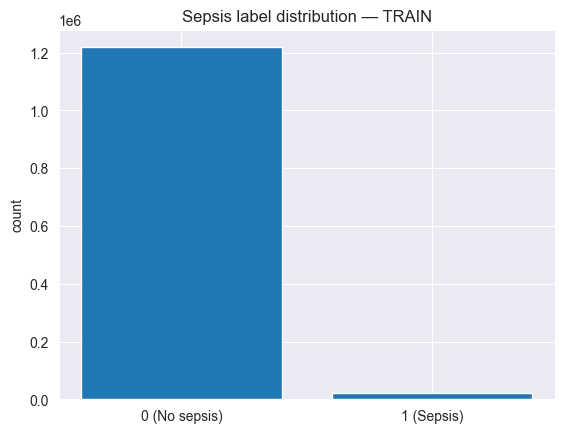

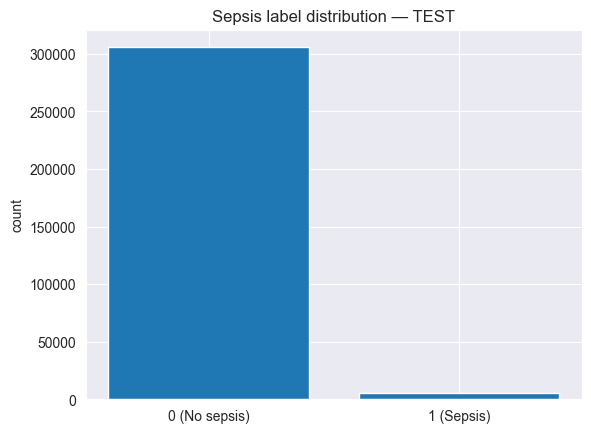

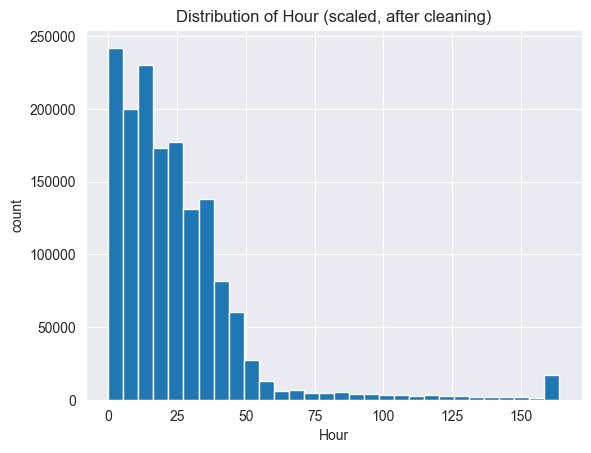

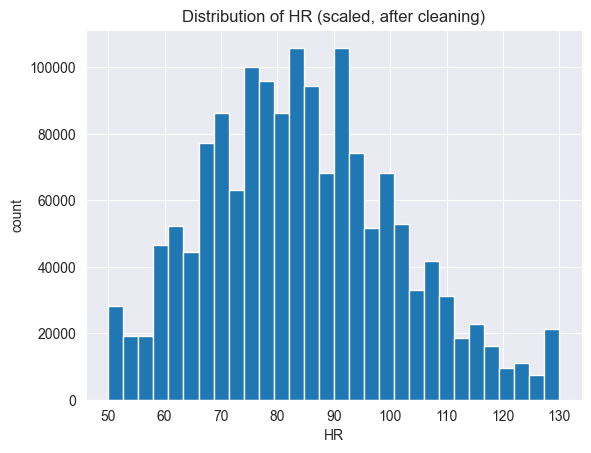

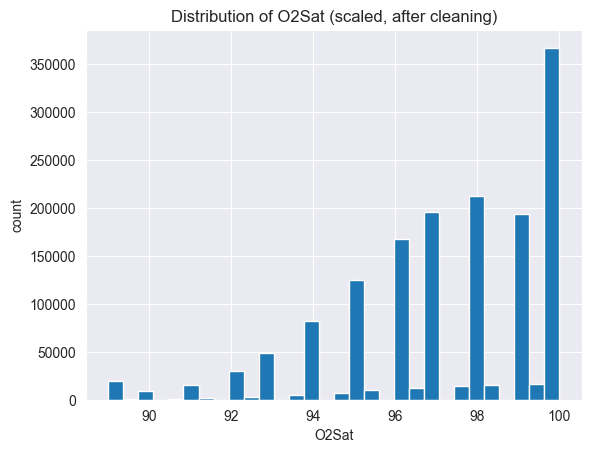

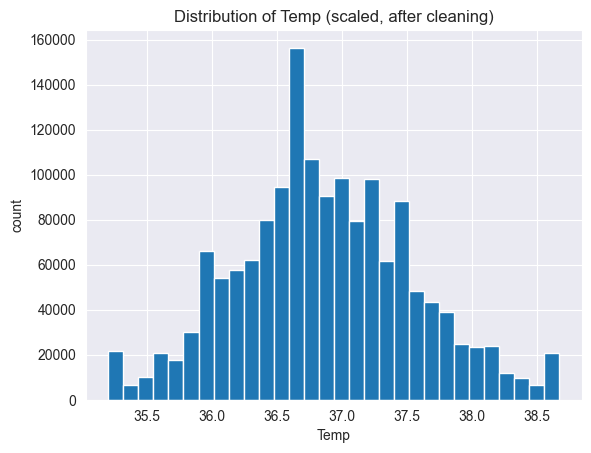

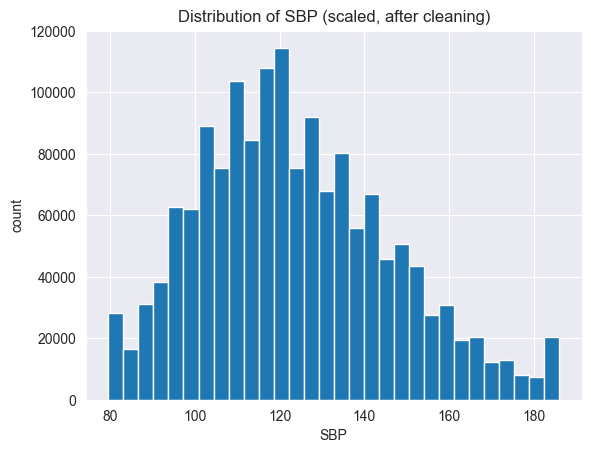

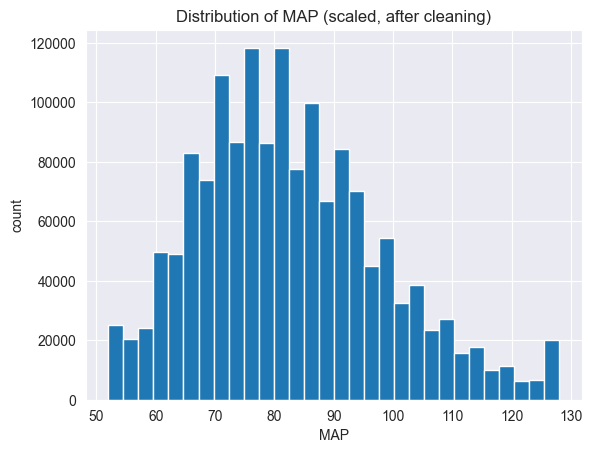

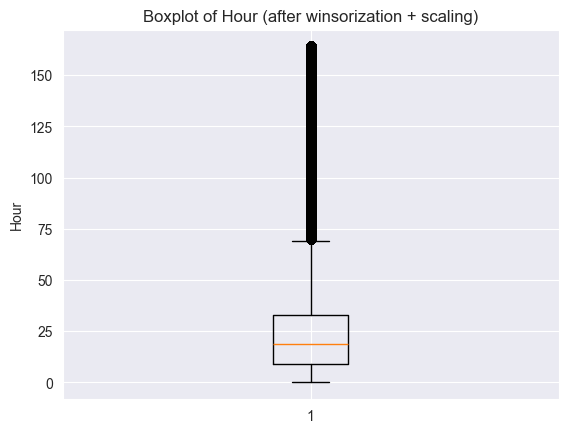

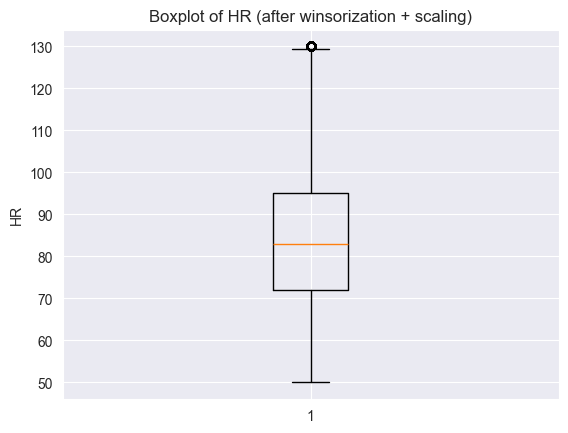

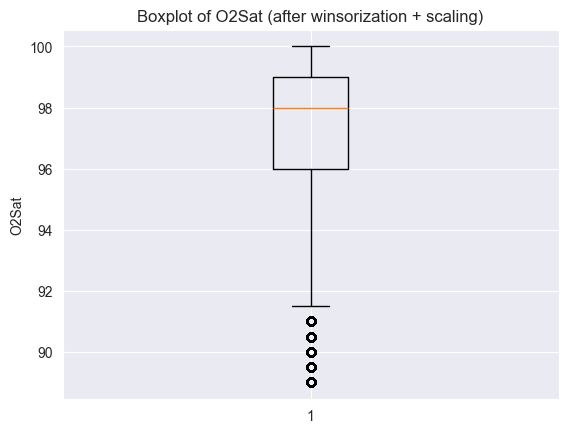

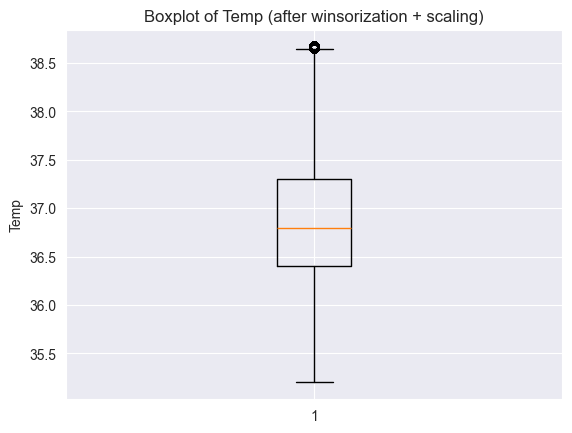

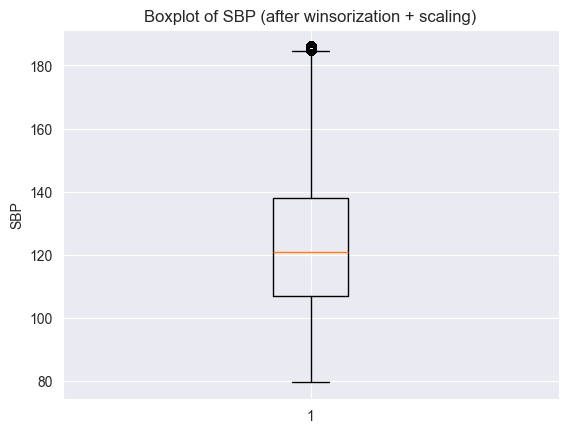

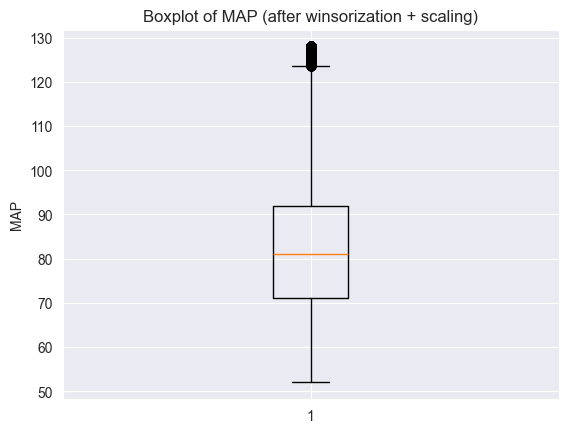

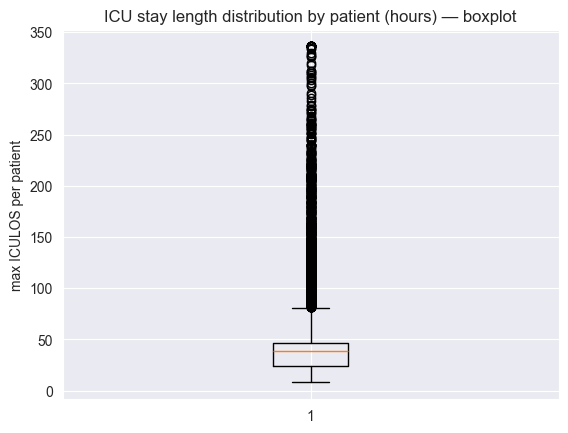

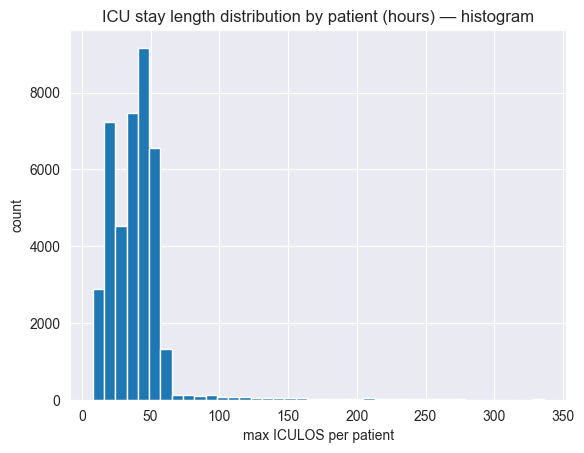


🦠 Random example sepsis patient for temporal check: 114893


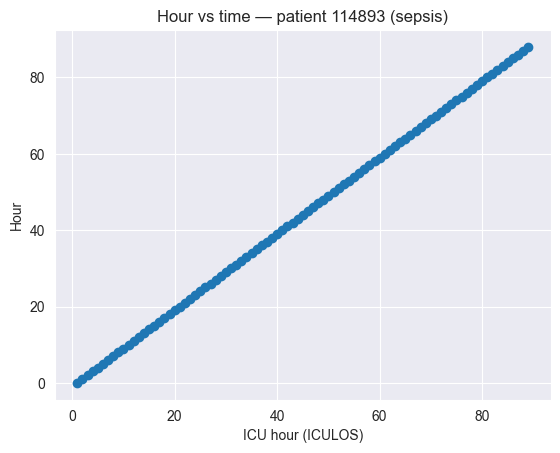

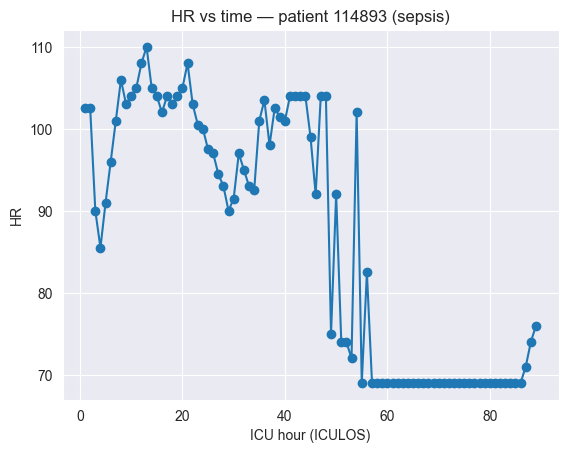

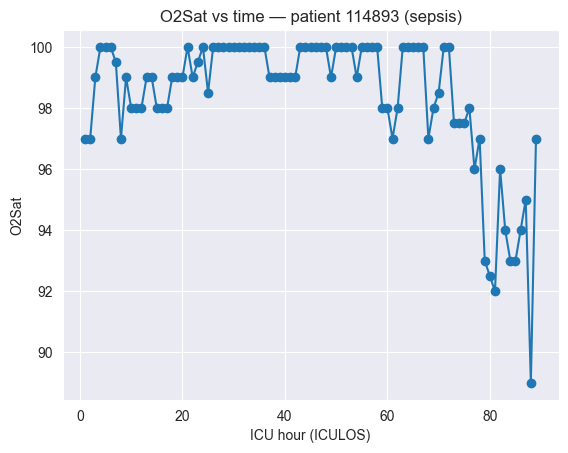


💚 Random example non-sepsis patient for temporal check: 9568


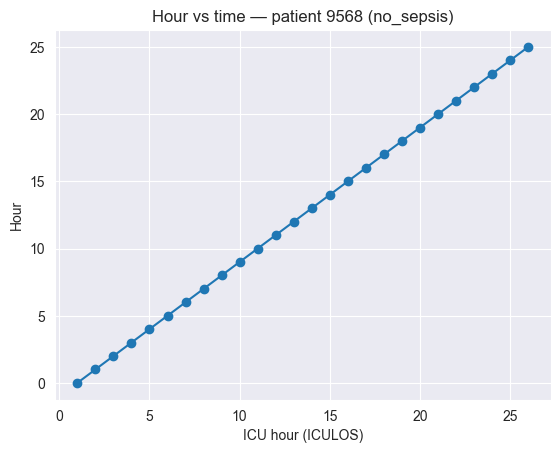

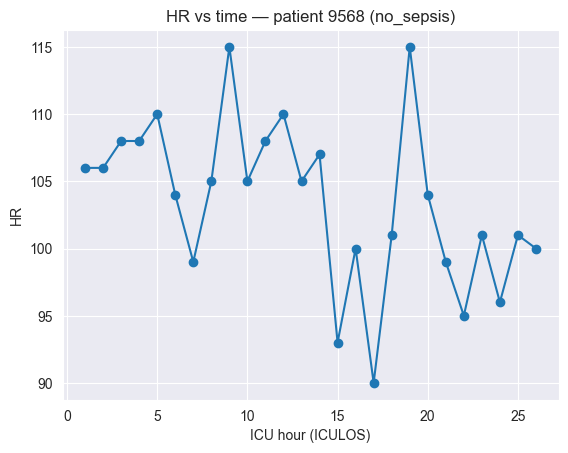

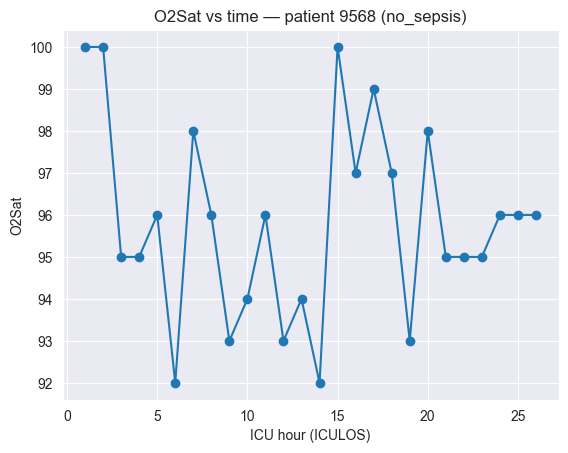

In [60]:
print("🔍 SepsisLabel ratio in TRAIN set:")
print(train_df[TARGET_COL].value_counts())
print(train_df[TARGET_COL].value_counts(normalize=True))

print("\n🔍 SepsisLabel ratio in TEST set:")
print(test_df[TARGET_COL].value_counts())
print(test_df[TARGET_COL].value_counts(normalize=True))

# ---- 1. Label distributions (step 7.1)
fig, ax = plt.subplots()
ax.bar(
    ["0 (No sepsis)", "1 (Sepsis)"],
    train_df[TARGET_COL].value_counts().reindex([0, 1]).values
)
ax.set_title("Sepsis label distribution — TRAIN")
ax.set_ylabel("count")
EXPORTED_FIGURES.append(("step7.1_label_distribution_train", fig))
plt.show()

fig, ax = plt.subplots()
ax.bar(
    ["0 (No sepsis)", "1 (Sepsis)"],
    test_df[TARGET_COL].value_counts().reindex([0, 1]).values
)
ax.set_title("Sepsis label distribution — TEST")
ax.set_ylabel("count")
EXPORTED_FIGURES.append(("step7.1_label_distribution_test", fig))
plt.show()

# ---- 2. Numeric distributions preview after scaling (histograms) — step 7.2
audit_cols = numeric_cols[:6]  # same sample features you inspected earlier

for col in audit_cols:
    vals = df[col].dropna()
    fig, ax = plt.subplots()
    ax.hist(vals, bins=30)
    ax.set_title(f"Distribution of {col} (scaled, after cleaning)")
    ax.set_xlabel(col)
    ax.set_ylabel("count")
    EXPORTED_FIGURES.append((f"step7.2_hist_{col}_scaled_after_cleaning", fig))
    plt.show()

# ---- 3. Boxplots to confirm outlier caps — step 7.3
for col in audit_cols:
    fig, ax = plt.subplots()
    ax.boxplot(df[col].dropna())
    ax.set_title(f"Boxplot of {col} (after winsorization + scaling)")
    ax.set_ylabel(col)
    EXPORTED_FIGURES.append((f"step7.3_box_{col}_after_winsorization_scaling", fig))
    plt.show()

# ---- 4. ICU stay length per patient sanity check — step 7.4
stay_lengths = df.groupby(P_ID_COL)[TIME_COL].max()

fig, ax = plt.subplots()
ax.boxplot(stay_lengths.dropna())
ax.set_title("ICU stay length distribution by patient (hours) — boxplot")
ax.set_ylabel("max ICULOS per patient")
EXPORTED_FIGURES.append(("step7.4_stay_length_boxplot", fig))
plt.show()

fig, ax = plt.subplots()
ax.hist(stay_lengths.dropna(), bins=40)
ax.set_title("ICU stay length distribution by patient (hours) — histogram")
ax.set_xlabel("max ICULOS per patient")
ax.set_ylabel("count")
EXPORTED_FIGURES.append(("step7.4_stay_length_histogram", fig))
plt.show()

# ---- 5. Optional: visualize 1 random patient timeline per class again — step 7.5
pos_patients = df.loc[df[TARGET_COL] == 1, P_ID_COL].unique()
neg_patients = df.loc[df[TARGET_COL] == 0, P_ID_COL].unique()

example_pos = np.random.choice(pos_patients) if len(pos_patients) > 0 else None
example_neg = np.random.choice(neg_patients) if len(neg_patients) > 0 else None

def plot_patient(patient_id, tag):
    sub = df[df[P_ID_COL] == patient_id].sort_values(TIME_COL)
    for v in audit_cols[:3]:  # just 3 signals overlayed
        fig, ax = plt.subplots()
        ax.plot(sub[TIME_COL], sub[v], marker="o")
        ax.set_title(f"{v} vs time — patient {patient_id} ({tag})")
        ax.set_xlabel("ICU hour (ICULOS)")
        ax.set_ylabel(v)
        ax.grid(True)
        key = f"step7.5_patient_{tag}_id{patient_id}_{v}_timeline"
        EXPORTED_FIGURES.append((key, fig))
        plt.show()

if example_pos is not None:
    print("\n🦠 Random example sepsis patient for temporal check:", example_pos)
    plot_patient(example_pos, "sepsis")

if example_neg is not None:
    print("\n💚 Random example non-sepsis patient for temporal check:", example_neg)
    plot_patient(example_neg, "no_sepsis")


###  Final Step — Save Outputs From Notebook 01 (Preprocessing)

In [61]:
from pathlib import Path
import matplotlib.pyplot as plt

# Identify project root = the 'sepsis-predictor' folder
# If current dir is notebooks/, go one level up to sepsis-predictor
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Base report directories (inside sepsis-predictor)
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures" / "01_preprocessing"
RESULTS_DIR = REPORTS_DIR / "results" / "01_preprocessing"

# Ensure directories exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Save Preprocessed Datasets
# ---------------------------
full_path  = RESULTS_DIR / "01_preprocessing_full.csv"
train_path = RESULTS_DIR / "01_preprocessing_train.csv"
test_path  = RESULTS_DIR / "01_preprocessing_test.csv"

df.to_csv(full_path, index=False)
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("📁 Saved datasets to:", RESULTS_DIR)
print("   ", full_path.name)
print("   ", train_path.name)
print("   ", test_path.name)

# ---------------------------
# Save Figures (optional)
# ---------------------------
fig_infos = globals().get("EXPORTED_FIGURES", [])

if fig_infos:
    print("\n🖼️ Saving figures to:", FIGURES_DIR)
    for idx, item in enumerate(fig_infos, start=1):
        if isinstance(item, plt.Figure):
            name = f"unnamed_fig{idx}"
            fig = item
        else:
            try:
                name, fig = item
            except Exception:
                name = f"unnamed_fig{idx}"
                fig = item

        fname = FIGURES_DIR / f"01_preprocessing_{name}.png"
        fig.savefig(fname, bbox_inches="tight")
        print("   ", fname.name)
else:
    print("\n🖼️ No figures found to save.")

print("\n✅ Notebook 01 export completed.")


📁 Saved datasets to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\01_preprocessing
    01_preprocessing_full.csv
    01_preprocessing_train.csv
    01_preprocessing_test.csv

🖼️ Saving figures to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\01_preprocessing
    01_preprocessing_step3.1_missing_values_heatmap.png
    01_preprocessing_step3.1_target_distribution_before_preprocessing.png
    01_preprocessing_step3.1_correlation_matrix.png
    01_preprocessing_step3.2_hist_Hour_raw.png
    01_preprocessing_step3.2_hist_HR_raw.png
    01_preprocessing_step3.2_hist_O2Sat_raw.png
    01_preprocessing_step3.2_hist_Temp_raw.png
    01_preprocessing_step3.2_hist_SBP_raw.png
    01_preprocessing_step3.2_hist_MAP_raw.png
    01_preprocessing_step3.2_box_Hour_raw.png
    01_preprocessing_step3.2_box_HR_raw.png
    01_preprocessing_step3.2_box_O2Sat_raw.png
    01_preprocessing_step3.2_box_Temp_raw.png
    01_preprocessing_step3.2_box_SBP_raw.png
    01_p